In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score,
                             f1_score, precision_score, recall_score, accuracy_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load the provider-level features dataset
df = pd.read_csv('Provider_Level_Features.csv')

print("=" * 70)
print("STEP 1: PREPARE MODELING DATASET")
print("=" * 70)

# Display basic info
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nFirst Few Rows:")
print(df.head())

STEP 1: PREPARE MODELING DATASET

Dataset Shape: (5410, 40)

Column Names:
['Provider', 'TotalReimbursement', 'AvgReimbursement', 'StdReimbursement', 'MaxReimbursement', 'MinReimbursement', 'TotalDeductible', 'AvgDeductible', 'TotalClaims', 'UniquePatients', 'AvgAge', 'StdAge', 'MinAge', 'MaxAge', 'MaleRatio', 'DeceasedRatio', 'AvgClaimDuration', 'StdClaimDuration', 'MaxClaimDuration', 'AvgAdmissionDuration', 'MaxAdmissionDuration', 'ChronicCond_Alzheimer_Prevalence', 'ChronicCond_Heartfailure_Prevalence', 'ChronicCond_KidneyDisease_Prevalence', 'ChronicCond_Cancer_Prevalence', 'ChronicCond_ObstrPulmonary_Prevalence', 'ChronicCond_Depression_Prevalence', 'ChronicCond_Diabetes_Prevalence', 'ChronicCond_IschemicHeart_Prevalence', 'ChronicCond_Osteoporasis_Prevalence', 'ChronicCond_rheumatoidarthritis_Prevalence', 'ChronicCond_stroke_Prevalence', 'RenalDiseaseIndicator_Prevalence', 'InpatientRatio', 'ClaimsPerPatient', 'ReimbursementPerPatient', 'ReimbursementPerClaim', 'OutpatientRatio',

In [2]:
# Identify target and features
# Assuming 'ExclusionLabel' or similar is the target variable
# Adjust column name based on actual data

# Find the target column (likely named something like 'Excluded', 'ExclusionLabel', 'is_excluded', etc.)
potential_targets = ['ExclusionLabel', 'Excluded', 'is_excluded', 'target', 'label', 'fraud', 'exclusion']
target_col = None

for col in df.columns:
    if col.lower() in [t.lower() for t in potential_targets]:
        target_col = col
        break

# If not found, assume last column or look for binary column
if target_col is None:
    # Check for binary columns
    for col in df.columns:
        if df[col].nunique() == 2 and df[col].dtype in ['int64', 'float64']:
            unique_vals = set(df[col].dropna().unique())
            if unique_vals.issubset({0, 1, 0.0, 1.0}):
                target_col = col
                print(f"Identified potential target column: {col}")
                break

print(f"\nTarget Column: {target_col}")
print(f"\nTarget Distribution:")
print(df[target_col].value_counts())
print(f"\nTarget Percentage:")
print(df[target_col].value_counts(normalize=True) * 100)

# Separate features and target
# Exclude identifier columns
id_columns = ['Provider', 'ProviderID', 'provider_id', 'NPI', 'ID']
exclude_cols = [col for col in df.columns if col in id_columns or col == target_col]

X = df.drop(columns=exclude_cols, errors='ignore')
y = df[target_col]

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")

# Check for any remaining non-numeric columns
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"\nNon-numeric columns to handle: {non_numeric}")
    # One-hot encode or drop
    X = pd.get_dummies(X, columns=non_numeric, drop_first=True)
    print(f"Shape after encoding: {X.shape}")



Identified potential target column: PotentialFraud_Binary

Target Column: PotentialFraud_Binary

Target Distribution:
PotentialFraud_Binary
0    4904
1     506
Name: count, dtype: int64

Target Percentage:
PotentialFraud_Binary
0    90.64695
1     9.35305
Name: proportion, dtype: float64

Feature Matrix Shape: (5410, 38)
Target Vector Shape: (5410,)

Non-numeric columns to handle: ['PotentialFraud']
Shape after encoding: (5410, 38)



DATASET SPLITS

Set                Samples   Percentage    Pos Class   Pos Rate
------------------------------------------------------------
Training              3246        60.0%          304      9.37%
Validation            1082        20.0%          101      9.33%
Test                  1082        20.0%          101      9.33%

Total                 5410       100.0%


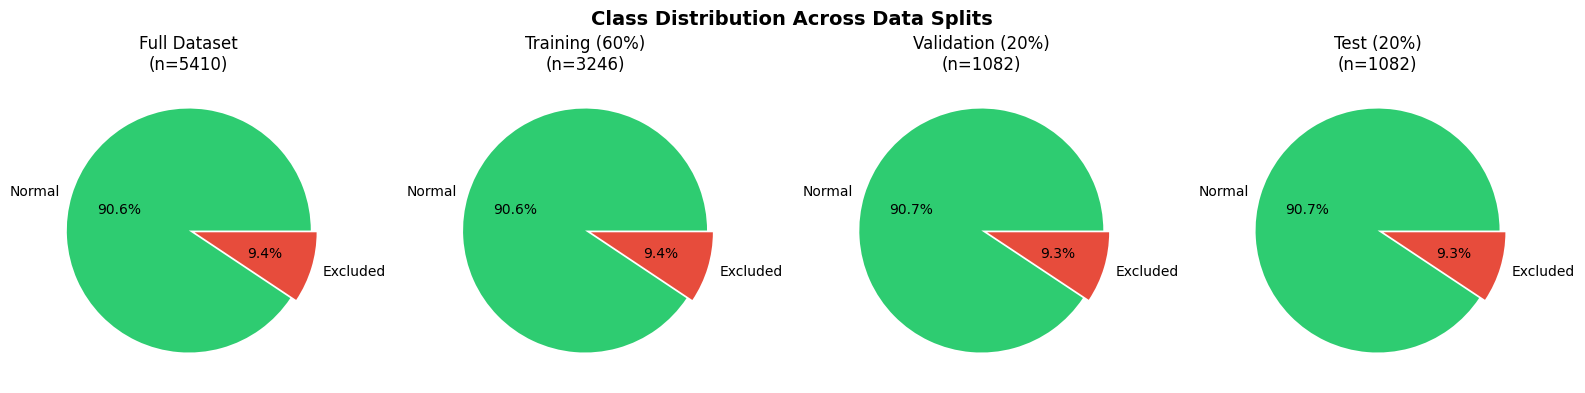

In [3]:
# First split: 60% train, 40% temp (will become 20% val + 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.40,
    random_state=RANDOM_STATE,
    stratify=y  # Maintain class distribution
)

# Second split: 50% of temp = 20% val, 50% of temp = 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print("\n" + "=" * 50)
print("DATASET SPLITS")
print("=" * 50)

print(f"\n{'Set':<15} {'Samples':>10} {'Percentage':>12} {'Pos Class':>12} {'Pos Rate':>10}")
print("-" * 60)

for name, X_set, y_set in [('Training', X_train, y_train),
                            ('Validation', X_val, y_val),
                            ('Test', X_test, y_test)]:
    pos_count = y_set.sum()
    pos_rate = y_set.mean() * 100
    pct = len(y_set) / len(y) * 100
    print(f"{name:<15} {len(y_set):>10} {pct:>11.1f}% {pos_count:>12} {pos_rate:>9.2f}%")

print(f"\n{'Total':<15} {len(y):>10} {'100.0%':>12}")

# Visualize the splits
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

datasets = [('Full Dataset', y), ('Training (60%)', y_train),
            ('Validation (20%)', y_val), ('Test (20%)', y_test)]

for ax, (name, data) in zip(axes, datasets):
    counts = data.value_counts()
    colors = ['#2ecc71', '#e74c3c']
    ax.pie(counts, labels=['Normal', 'Excluded'], autopct='%1.1f%%',
           colors=colors, explode=(0, 0.05))
    ax.set_title(f'{name}\n(n={len(data)})')

plt.suptitle('Class Distribution Across Data Splits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('data_splits_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [4]:
# Check for missing values
print("\n" + "=" * 50)
print("MISSING VALUE ANALYSIS")
print("=" * 50)

missing_train = X_train.isnull().sum()
missing_pct = (missing_train / len(X_train) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing_train,
    'Missing %': missing_pct
}).query('`Missing Count` > 0').sort_values('Missing %', ascending=False)

if len(missing_df) > 0:
    print(f"\nFeatures with Missing Values:")
    print(missing_df)

    # Fill missing values with median (from training set only)
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')

    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_val_imputed = pd.DataFrame(
        imputer.transform(X_val),
        columns=X_val.columns,
        index=X_val.index
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    X_train, X_val, X_test = X_train_imputed, X_val_imputed, X_test_imputed
    print("\n✓ Missing values imputed with median")
else:
    print("\n✓ No missing values found!")

# Store feature names for later use
feature_names = X_train.columns.tolist()
print(f"\nTotal Features: {len(feature_names)}")


MISSING VALUE ANALYSIS

✓ No missing values found!

Total Features: 38


In [5]:
print("\n" + "=" * 70)
print("STEP 2: HANDLE CLASS IMBALANCE")
print("=" * 70)

# Calculate imbalance ratio
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Minority Class (Excluded): {y_train.sum()} samples ({y_train.mean()*100:.2f}%)")
print(f"Majority Class (Normal): {len(y_train) - y_train.sum()} samples ({(1-y_train.mean())*100:.2f}%)")

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


STEP 2: HANDLE CLASS IMBALANCE

Class Imbalance Ratio: 9.68:1
Minority Class (Excluded): 304 samples (9.37%)
Majority Class (Normal): 2942 samples (90.63%)


In [6]:
print("\n" + "-" * 50)
print("METHOD 1: Class Weighting")
print("-" * 50)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(f"\nComputed Class Weights:")
print(f"  Class 0 (Normal): {class_weight_dict[0]:.4f}")
print(f"  Class 1 (Excluded): {class_weight_dict[1]:.4f}")


--------------------------------------------------
METHOD 1: Class Weighting
--------------------------------------------------

Computed Class Weights:
  Class 0 (Normal): 0.5517
  Class 1 (Excluded): 5.3388
